In [57]:
import os

In [58]:
import pickle

In [59]:
random_seed = 42

In [60]:
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)

import pandas as pd
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.max_colwidth', -1)

In [61]:
import csv

In [62]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

In [63]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset

In [64]:
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [65]:
from tqdm import tqdm

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [67]:
from scipy import stats

In [68]:
def get_prob(label, prob):
    return prob[label]

In [90]:
output_collections_list = []
for idx in range(0, 9000+1, 1000):
    with open("saved/score_42/{}.pkl".format(idx), "rb") as handle:
        output_collections = pickle.load(handle)    
        print(output_collections[0]['prob'])
        print(len(output_collections))
        
    if idx==0:
        output_collections_list = output_collections
    else:
        output_collections_list += output_collections
len(output_collections_list)        

[1.3119584e-06 1.6234579e-06 4.4109314e-05 1.3470741e-04 1.0314246e-05
 9.6942771e-05 9.9966776e-01 1.5807591e-06 8.2067181e-06 3.3498505e-05]
1000
[0.00296345 0.01543871 0.20667087 0.08410855 0.10940073 0.36600584
 0.00233175 0.1709157  0.00100259 0.04116183]
1000
[0.03537454 0.00897479 0.36102456 0.05171341 0.02095333 0.00722984
 0.2574968  0.22482738 0.0155394  0.01686599]
1000
[1.3831571e-03 2.7952669e-03 6.5201825e-06 6.4640801e-05 2.8206514e-06
 2.7173216e-06 9.7886441e-06 4.5515499e-05 8.5003092e-04 9.9483949e-01]
1000
[9.9986207e-01 5.4976731e-06 9.7504271e-05 1.2431217e-06 3.3806380e-06
 1.3077515e-07 6.2407008e-07 2.6388716e-06 1.5650423e-05 1.1368608e-05]
1000
[6.3092459e-04 8.7274838e-04 2.8286800e-03 8.4994286e-01 4.3542974e-02
 8.7668546e-02 8.7624583e-03 4.2916210e-03 4.5917073e-04 9.9998806e-04]
1000
[2.1776385e-04 5.0199546e-05 9.7584164e-01 3.6946794e-03 8.3056157e-03
 2.2447994e-03 8.2336401e-04 8.6970748e-03 8.2834544e-05 4.2095326e-05]
1000
[3.6450803e-02 1.4732902

10000

In [91]:
data = []
for i in output_collections_list:
    data.append([i['index'], i['prob'], i['label'], i['prediction'],
                 i['influence_prime'], 
                 i['influence'], 
                 i['diff'], 
                 i['theta'], i['attributions'],
                ])

df_0 = pd.DataFrame(data, columns=['cifar_index', 'prob', 'label', 'prediction',
                                   'influence_prime', 'influence', 'diff', 
                                   'theta', 'attributions'
                                  ])



df_0['theta'] = -df_0['theta']
df_0['attributions'] = -df_0['attributions']

In [92]:
df_0['rank'] = df_0['influence'].rank(method='first', ascending=False)

In [93]:
mean_squared_error(df_0['influence'], df_0['theta'])**0.5

0.045856371137171094

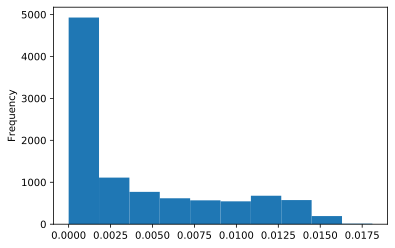

In [96]:
df_0['influence_prime'].plot.hist()

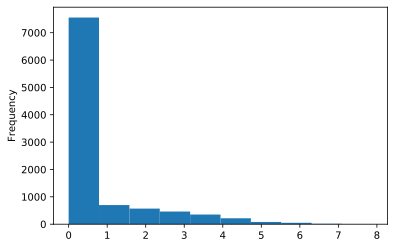

In [97]:
df_0['influence'].plot.hist()

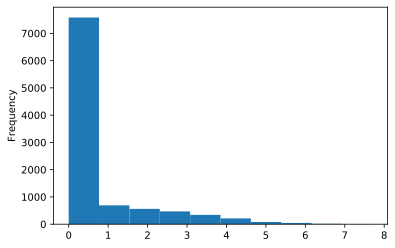

In [98]:
df_0['theta'].plot.hist()

In [99]:
drop_index = df_0[df_0['influence']<=0].index
len(drop_index)

156

In [100]:
df_0.loc[drop_index, 'influence'] = 0.0

In [101]:
def post_process(theta, attributions):
    if theta>0:
        return attributions
    else:
        return np.zeros(attributions.shape)

In [102]:
df_0['attributions'] = df_0.apply(lambda x: post_process(x['theta'], x['attributions']), axis=1)

In [103]:
drop_index = df_0[df_0['theta']<=0].index
len(drop_index)

2978

In [104]:
df_0.loc[drop_index, 'theta'] = 0.0

In [105]:
df_0.head()

,cifar_index,prob,label,prediction,influence_prime,influence,diff,theta,attributions,rank
0,22085,"[1.3119584e-06, 1.6234579e-06, 4.4109314e-05, 0.00013470741, 1.0314246e-05, 9.694277e-05, 0.99966776, 1.5807591e-06, 8.206718e-06, 3.3498505e-05]",6,6,0.000019,0.000002,0.000017,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",9641.0
1,27619,"[4.864812e-05, 4.8704683e-06, 7.428763e-05, 0.9909388, 0.00012184118, 0.004007219, 2.690463e-05, 0.004693093, 1.9216654e-05, 6.503695e-05]",3,3,0.000439,0.002397,-0.001958,0.000549848,"[[0.00016468317, 0.0003132546, 0.00024395133, 0.00016617573, -5.168926e-05, 0.00015806593, 0.00024872707], [0.00015713576, 0.00026138185, 0.0002058981, -0.00023555302, -0.00057897635, 2.4562643e-05, 0.00029577722], [0.00021128177, 0.00036398752, 0.00016698154, -0.0003195789, -0.00054090796, -0.00021227472, 0.00017140043], [0.00036943905, 0.0007034452, 0.00018385782, -0.00011714762, -0.00052356947, -0.00048591662, -0.00012523294], [0.0005292776, 0.0006242852, 0.00012229024, -0.0004957912, -0.0007916305, -0.0004840586, -0.00027817432], [0.0005957357, 0.00068719767, 0.00011326849, -0.00053324737, -0.00083562353, -0.00018959994, -8.027764e-05], [0.0005561438, 0.00037842727, 2.267044e-05, -0.00036789814, -0.00030965707, 0.00016413494, -9.6784635e-05]]",6919.0
2,44768,"[0.026609506, 0.004129501, 0.011076414, 0.8982037, 0.0031650027, 0.02853047, 0.022838613, 0.0014383021, 0.003186035, 0.00082247163]",3,3,0.004753,0.177722,-0.172970,0.156058,"[[0.009119876, 0.0102627985, 0.0105988635, 0.012518171, 0.011406256, 0.015515711, 0.013942325], [0.009810471, 0.008242508, 0.006017751, 0.007839027, 0.009563268, 0.016781412, 0.022784323], [0.0061160615, -0.005843211, -0.007378158, -0.0030327667, 0.0037918417, 0.015117446, 0.016205821], [-0.002533419, -0.0114298, -0.023219861, -0.021803822, -0.012619805, -0.002407484, -0.004383998], [-0.00557242, -0.009710664, -0.013058539, -0.0115881255, -0.006529215, 0.00028851, -0.0042110076], [0.003959695, 0.012940349, 0.0118369255, 0.00083043304, -0.004524667, -0.001907195, -0.002334787], [0.0132750105, 0.023765523, 0.020443656, 0.010418402, 0.0034336476, 0.0021816462, 0.001139076]]",3750.0
3,1716,"[0.0017301178, 4.852259e-06, 0.024318999, 0.000108334934, 0.88378596, 5.389357e-05, 4.2260865e-05, 0.089941606, 2.9360267e-06, 1.1039723e-05]",7,4,0.005088,2.893504,-2.888416,2.82469,"[[0.028512796, 0.03227394, 0.037093144, 0.05975295, 0.08380391, 0.09041656, 0.08192794], [0.027467445, 0.030143373, 0.0297487, 0.051321555, 0.067333885, 0.07371705, 0.062308032], [0.028285325, 0.03093737, 0.031124556, 0.035680264, 0.049115255, 0.042909715, 0.027262762], [0.034017965, 0.041863494, 0.046092223, 0.06433977, 0.07048719, 0.06621495, 0.04411184], [0.049974225, 0.058906786, 0.08146699, 0.094448924, 0.09095932, 0.08260273, 0.06274901], [0.05600787, 0.07187688, 0.086860135, 0.09534109, 0.07859121, 0.063325904, 0.054739505], [0.050489977, 0.0730943, 0.070690826, 0.070726305, 0.05569978, 0.051989183, 0.05588589]]",862.0
4,11711,"[0.00045886717, 0.00025985556, 0.0030399798, 0.0036731842, 0.0053413254, 0.0011917698, 0.9855258, 0.0002440223, 0.00016473517, 0.00010055059]",6,6,0.000783,0.004014,-0.003231,0.00101743,"[[0.00071651384, 0.00041775976, 0.00041133846, 0.0003059032, 0.00057861744, 0.00060427247, 0.00065953913], [0.00033830688, 0.0005003257, 4.036247e-05, -0.0006292901, -0.00032230615, 0.0005845122, -0.00027913443], [0.00012389797, -1.877237e-05, -0.0012675592, -0.0013769395, -0.00018652636, 0.0004740132, 0.00045906368], [0.0003260392, 0.00032647658, -0.00087052275, -0.0023184158, -0.001211301, -0.0001532197, 0.0005292204], [0.0001989264, 0.00088056794, -0.0006920191, -0.0018706876, -0.000230204, 0.0005517802, 0.0007015659], [0.00032418367, 0.0004565574, -0.00014382409, -0.00097121834, -0.000275

In [106]:
df_0['rank'].head()

0    9641.0
1    6919.0
2    3750.0
3    862.0 
4    6590.0
Name: rank, dtype: float64

In [107]:
mem_list = []
for i in range(0, 100, 10):
    k = int(len(df_0)*i/100)
    print(k)
    mem_list.append(df_0[df_0['rank']==k+1]['influence'].values[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [108]:
mem_list

[7.882788181304932,
 2.6482622623443604,
 1.2516711950302124,
 0.43612605333328247,
 0.13282029330730438,
 0.036054544150829315,
 0.00951551366597414,
 0.002116149291396141,
 0.000348960718838498,
 3.3709471608744934e-05]

In [110]:
df_0_sorted = df_0.sort_values(by=['influence'], ascending=False) 
df_0_sorted[['cifar_index', 'label', 'prediction', 'prob', 'influence', 
             'rank'
            ]].head()

,cifar_index,label,prediction,prob,influence,rank
2941,49176,0,7,"[0.2657535, 3.8441256e-05, 0.007261258, 0.0026374247, 0.029261295, 0.00028251173, 3.945214e-05, 0.6943985, 5.7917052e-05, 0.00026964865]",7.882788,1.0
6096,35546,0,7,"[0.40057325, 0.0008358438, 0.0028925603, 0.0030408062, 0.013642431, 0.0032770657, 3.0052533e-05, 0.5627032, 0.0014730357, 0.011531744]",7.027914,2.0
2398,28673,2,0,"[0.6293705, 1.290314e-05, 0.36457232, 0.00025439987, 1.14939785e-05, 1.1522492e-05, 0.0034991147, 0.0016374193, 0.0004895086, 0.0001408228]",6.901117,3.0
7764,4333,7,4,"[1.0082724e-05, 1.0119223e-05, 0.002458009, 0.00020969888, 0.68617344, 0.056152165, 0.00013523691, 0.25484782, 4.5372707e-07, 2.9700539e-06]",6.881802,4.0
6198,34233,1,8,"[0.0010900506, 0.20470734, 0.00040054665, 0.0003873721, 0.00012415125, 0.0003069317, 0.0036269536, 0.00010802219, 0.7718114, 0.017437208]",6.826882,5.0


In [42]:
np.random.seed(random_seed)

total = len(df_0)
for percentage in range(10, 100, 10):
    k = int(total*(percentage/100))
    print(percentage, k)
    
    tmp = df_0_sorted.head(k)
    print(classification_report(tmp['label'], tmp['prediction']))

    tmp = df_0.drop(tmp.index)
    print(tmp['label'].value_counts())
    
    filename = "data/mem/{}.csv".format(percentage)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    tmp[['cifar_index', 'label']].to_csv(filename, index=False)

10 1000
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        86
           1       0.68      0.59      0.63        78
           2       0.66      0.50      0.57       150
           3       0.39      0.45      0.42       135
           4       0.50      0.48      0.49       120
           5       0.49      0.42      0.45       118
           6       0.45      0.54      0.49        76
           7       0.58      0.64      0.61       107
           8       0.57      0.56      0.57        55
           9       0.55      0.52      0.53        75

    accuracy                           0.52      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.53      0.52      0.52      1000

8    945
9    925
6    924
1    922
0    914
7    893
5    882
4    880
3    865
2    850
Name: label, dtype: int64
20 2000
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       170


In [139]:
def get_random_attribution(attributions):
            
    return np.random.rand(7, 7)     

In [140]:
def get_mask(percentage, attributions):
    
    mask = np.zeros((7, 7))
    mask = mask.reshape(-1)
    
    length = len(mask)
    
    attributions = attributions.copy()
        
    k = int( percentage/100*(length))
    
    if k==0:
        k = 1
     
    indices = (-attributions.reshape(-1)).argsort()[:k] # top-k
    
    for i in indices:
        mask[i] = 1
        
    mask = mask.reshape(attributions.shape)
                
    return mask

In [141]:
df_attr = df_0_sorted.head(1000).copy()

In [142]:
df_attr.head()

,cifar_index,prob,label,prediction,influence_prime,influence,diff,theta,attributions,rank
2941,49176,"[0.2657535, 3.8441256e-05, 0.007261258, 0.0026374247, 0.029261295, 0.00028251173, 3.945214e-05, 0.6943985, 5.7917052e-05, 0.00026964865]",0,7,0.012610,7.882788,-7.870179,7.70037,"[[-0.0022292393, -0.010948432, -0.0016956506, -0.031289484, -0.06650637, -0.04244779, -0.022530245], [-0.03239602, -0.030115241, -0.04304223, -0.041416805, -0.041417506, 0.08160376, 0.11348109], [-0.014989436, 0.0003191065, 0.09124178, 0.12539527, 0.16178489, 0.2571203, 0.24865931], [0.041934922, 0.18202643, 0.39861125, 0.4669043, 0.27913773, 0.17985338, 0.09689039], [0.20457181, 0.35420203, 0.6094841, 0.6108748, 0.31288388, 0.053578295, -0.01750201], [0.22903088, 0.37396282, 0.5053977, 0.48795015, 0.2435295, 0.06703922, 0.027404774], [0.12934943, 0.22554338, 0.3178228, 0.2857417, 0.18909596, 0.08991439, 0.05655312]]",1.0
6096,35546,"[0.40057325, 0.0008358438, 0.0028925603, 0.0030408062, 0.013642431, 0.0032770657, 3.0052533e-05, 0.5627032, 0.0014730357, 0.011531744]",0,7,0.014902,7.027914,-7.013011,6.85277,"[[0.023938922, 0.016087048, 0.002679024, -0.06171302, -0.107324034, -0.13266705, -0.089392945], [-0.01758219, -0.010141188, 0.020803697, -0.010484124, -0.102048725, -0.10994067, -0.05803489], [-0.034257162, 0.06839169, 0.23132755, 0.25729787, 0.04832518, -0.1248526, -0.1077542], [0.012337999, 0.22761056, 0.37826607, 0.40623263, 0.21649206, 0.01180096, -0.08015835], [0.24952686, 0.42906374, 0.48006475, 0.4034351, 0.3689447, 0.2937259, 0.12622526], [0.20874241, 0.39506322, 0.43953305, 0.35196793, 0.3216811, 0.3887487, 0.2839564], [0.12127741, 0.23840627, 0.26450944, 0.23235959, 0.1612969, 0.14809975, 0.07090576]]",2.0
2398,28673,"[0.6293705, 1.290314e-05, 0.36457232, 0.00025439987, 1.14939785e-05, 1.1522492e-05, 0.0034991147, 0.0016374193, 0.0004895086, 0.0001408228]",2,0,0.013751,6.901117,-6.887366,6.72872,"[[0.07612382, 0.06493732, 0.110242255, 0.104769245, 0.03222501, 0.004847533, 0.03721253], [0.049213246, 0.008010268, 0.19563928, 0.24234667, 0.15399434, 0.017610645, 0.020961981], [0.037084047, 0.06751107, 0.24672306, 0.3781171, 0.24885282, 0.04692768, 0.031031925], [0.00950603, 0.115455724, 0.28522077, 0.33807558, 0.23133118, 0.076909296, 0.01865351], [0.022380125, 0.25849032, 0.41166523, 0.42270106, 0.25099516, 0.12482202, 0.05911338], [0.030817281, 0.15785933, 0.251344, 0.2836576, 0.15054758, 0.14385091, 0.13162719], [0.021115923, 0.05266595, 0.14101993, 0.13660634, 0.066118166, 0.10492203, 0.25686526]]",3.0
7764,4333,"[1.0082724e-05, 1.0119223e-05, 0.002458009, 0.00020969888, 0.68617344, 0.056152165, 0.00013523691, 0.25484782, 4.5372707e-07, 2.9700539e-06]",7,4,0.010732,6.881802,-6.871070,6.72563,"[[0.066734195, 0.07449021, 0.08214487, 0.11020673, 0.08648628, 0.07240754, 0.079852656], [0.09422851, 0.1517752, 0.21491292, 0.17051405, 0.12350914, 0.08767363, 0.09465131], [0.1146209, 0.2125446, 0.23449875, 0.18059136, 0.045928553, 0.029635696, 0.04136741], [0.1265521, 0.1605407, 0.16250712, 0.19259143, 0.119156785, 0.10987902, -0.019404396], [0.10707124, 0.09054345, 0.16388875, 0.35424465, 0.34612614, 0.32169408, 0.050705828], [0.12174533, 0.14012751, 0.15546085, 0.2967342, 0.2485759, 0.20364538, 0.06784441], [0.0800675, 0.09435943, 0.11081749, 0.14962684, 0.17302912, 0.12863389, 0.100090586]]",4.0
6198,34233,"[0.0010900506, 0.20470734, 0.00040054665, 0.0003873721, 0.00012415125, 0.0003069317, 0.0036269536, 0.00010802219, 0.7718114, 0.017437208]",1,8,0.010340,6.826882,-6.816542,6.68046,"[[0.030924223, 0.03995934, 0.013685059, 0.0341077, 0.012180357, 0.008158267, -0.009225754], [-0.00382041, 0.012898695, 0.07006527, 0.08872421, 0.09215749, 0.0060593635, -0.042457193], [-0.03927632, 0.03133829, 0.21927588, 0.25006104, 0.17081243, 0.035486765, -0.057912916], [0.018282756, 0.106067486, 0.27601567, 0.29082006, 0.22629872, 0.082223654, -0.028604101], [0.12475473, 0.26279163, 0.42472136, 0.3651954, 0.33015224, 0.1613028, 0.076264165], [0.13108927, 0.313

In [143]:
df_attr['label'].value_counts()

2    150
3    135
4    120
5    118
7    107
0    86 
1    78 
6    76 
9    75 
8    55 
Name: label, dtype: int64

In [144]:
for percentage in range(0, 100, 10):
    print(percentage)
    ####
    df_attr['mask'] = df_attr.apply(lambda x: get_mask(percentage, x['attributions']), axis=1)
    
    filename = "data/mem/{}.pkl".format(percentage)
    os.makedirs(os.path.dirname(filename), exist_ok=True)   
    
    with open(filename, "wb") as handle:
        pickle.dump(df_attr['mask'].values.tolist(), handle)  

0
10
20
30
40
50
60
70
80
90


In [145]:
np.random.seed(0)
df_attr['random_attributions'] = df_attr.apply(lambda x: get_random_attribution(x['attributions']), axis=1)
      
for percentage in range(0, 100, 10):
    print(percentage)  
    ####
    df_attr['mask'] = df_attr.apply(lambda x: get_mask(percentage, x['random_attributions']), axis=1)
  
    filename = "data/random_0/{}.pkl".format(percentage)
    os.makedirs(os.path.dirname(filename), exist_ok=True)   
    
    with open(filename, "wb") as handle:
        pickle.dump(df_attr['mask'].values.tolist(), handle)  

0
10
20
30
40
50
60
70
80
90


In [146]:
np.random.seed(2)
df_attr['random_attributions'] = df_attr.apply(lambda x: get_random_attribution(x['attributions']), axis=1)
      
for percentage in range(0, 100, 10):
    print(percentage)  
    ####
    df_attr['mask'] = df_attr.apply(lambda x: get_mask(percentage, x['random_attributions']), axis=1)
  
    filename = "data/random_2/{}.pkl".format(percentage)
    os.makedirs(os.path.dirname(filename), exist_ok=True)   
    
    with open(filename, "wb") as handle:
        pickle.dump(df_attr['mask'].values.tolist(), handle)  

0
10
20
30
40
50
60
70
80
90


In [147]:
np.random.seed(42)
df_attr['random_attributions'] = df_attr.apply(lambda x: get_random_attribution(x['attributions']), axis=1)
      
for percentage in range(0, 100, 10):
    print(percentage)  
    ####
    df_attr['mask'] = df_attr.apply(lambda x: get_mask(percentage, x['random_attributions']), axis=1)
  
    filename = "data/random/{}.pkl".format(percentage)
    os.makedirs(os.path.dirname(filename), exist_ok=True)   
    
    with open(filename, "wb") as handle:
        pickle.dump(df_attr['mask'].values.tolist(), handle)  

0
10
20
30
40
50
60
70
80
90


In [149]:
df = df_attr[[ 'cifar_index', 'label']].copy()
df['sample_index'] = range(len(df))
df.head()

,cifar_index,label,sample_index
2941,49176,0,0
6096,35546,0,1
2398,28673,2,2
7764,4333,7,3
6198,34233,1,4


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 2941 to 9210
Data columns (total 3 columns):
cifar_index     1000 non-null int64
label           1000 non-null int64
sample_index    1000 non-null int64
dtypes: int64(3)
memory usage: 31.2 KB


In [151]:
filename = "data/attr.csv".format(percentage)
os.makedirs(os.path.dirname(filename), exist_ok=True)

df.to_csv(filename, index=False)